# 04 - Classificando patologias em toras usando combinação de `OTSU_threshold + LBP + SVM`

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'broca': 0,
                'fissura': 1,
                'musgo': 2,
                'quebra': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    img_otsu = img >= threshold_otsu(img)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_toras.csv')
data

broca: 298 amostras
fissura: 2766 amostras
musgo: 505 amostras
quebra: 679 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,17.0,35.0,0.0,5.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,57.0,0.0,46.0,0.0,44.0,0.0,10288.0,142.0,0
1,55.0,82.0,0.0,32.0,0.0,81.0,0.0,32.0,0.0,0.0,...,0.0,135.0,0.0,100.0,0.0,110.0,0.0,22231.0,592.0,0
2,7.0,18.0,0.0,15.0,0.0,19.0,0.0,10.0,0.0,0.0,...,0.0,80.0,0.0,127.0,0.0,133.0,0.0,23407.0,148.0,0
3,2.0,2.0,0.0,11.0,0.0,1.0,0.0,8.0,0.0,0.0,...,0.0,102.0,0.0,177.0,0.0,137.0,0.0,72782.0,56.0,0
4,59.0,108.0,0.0,69.0,0.0,112.0,0.0,78.0,0.0,0.0,...,0.0,199.0,0.0,244.0,0.0,217.0,0.0,21011.0,808.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,5.0,22.0,0.0,16.0,0.0,26.0,0.0,13.0,0.0,0.0,...,0.0,88.0,0.0,61.0,0.0,121.0,0.0,11215.0,209.0,3
1188,23.0,58.0,0.0,30.0,0.0,59.0,0.0,25.0,0.0,0.0,...,0.0,78.0,0.0,31.0,0.0,58.0,0.0,13352.0,509.0,3
1189,8.0,11.0,0.0,16.0,0.0,14.0,0.0,11.0,0.0,0.0,...,0.0,99.0,0.0,50.0,0.0,64.0,0.0,7911.0,127.0,3
1190,18.0,44.0,0.0,26.0,0.0,47.0,0.0,13.0,0.0,0.0,...,0.0,64.0,0.0,50.0,0.0,69.0,0.0,6957.0,418.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 3072
              precision    recall  f1-score   support

       broca       0.94      0.94      0.94        78
     fissura       0.94      0.93      0.94       106
       musgo       0.93      0.92      0.92        85
      quebra       0.93      0.96      0.94        89

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



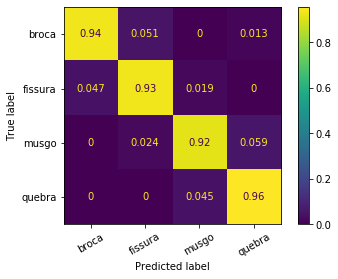

Rodada 1	-	Seed 2424
              precision    recall  f1-score   support

       broca       0.99      0.91      0.95        93
     fissura       0.92      0.97      0.94        79
       musgo       0.90      0.99      0.94        89
      quebra       0.98      0.91      0.94        97

    accuracy                           0.94       358
   macro avg       0.95      0.95      0.94       358
weighted avg       0.95      0.94      0.94       358



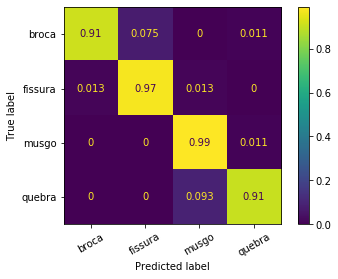

Rodada 2	-	Seed 1832
              precision    recall  f1-score   support

       broca       0.99      0.93      0.96        83
     fissura       0.96      0.97      0.96        93
       musgo       0.92      1.00      0.96        93
      quebra       1.00      0.96      0.98        89

    accuracy                           0.96       358
   macro avg       0.97      0.96      0.96       358
weighted avg       0.97      0.96      0.96       358



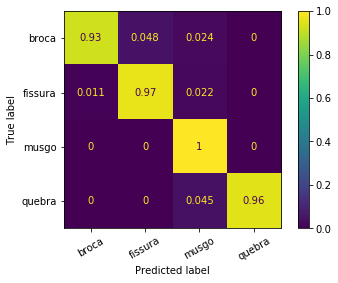

Rodada 3	-	Seed 4917
              precision    recall  f1-score   support

       broca       0.95      0.98      0.96        82
     fissura       0.98      0.93      0.96        92
       musgo       0.94      0.97      0.96       104
      quebra       0.96      0.95      0.96        80

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



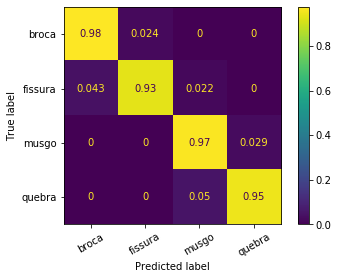

Rodada 4	-	Seed 5124
              precision    recall  f1-score   support

       broca       0.95      0.97      0.96        78
     fissura       0.97      0.94      0.96        82
       musgo       0.93      0.99      0.96        92
      quebra       0.99      0.94      0.97       106

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



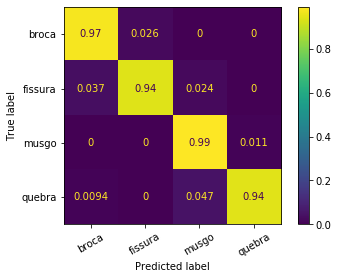

Rodada 5	-	Seed 1651
              precision    recall  f1-score   support

       broca       0.92      0.91      0.91        85
     fissura       0.92      0.91      0.92        90
       musgo       0.94      0.98      0.96        98
      quebra       0.98      0.95      0.96        85

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



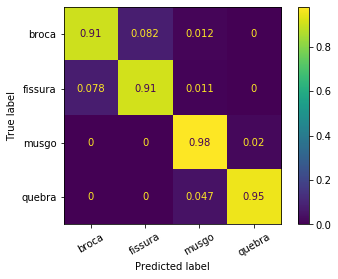

Rodada 6	-	Seed 5512
              precision    recall  f1-score   support

       broca       0.97      0.97      0.97        88
     fissura       0.94      0.94      0.94        83
       musgo       0.91      0.96      0.93       100
      quebra       0.98      0.91      0.94        87

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.95      0.94      0.94       358



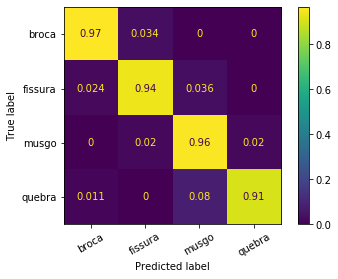

Rodada 7	-	Seed 4000
              precision    recall  f1-score   support

       broca       0.95      0.98      0.96        96
     fissura       0.95      0.90      0.92        82
       musgo       0.89      0.95      0.92        93
      quebra       0.96      0.91      0.93        87

    accuracy                           0.94       358
   macro avg       0.94      0.93      0.94       358
weighted avg       0.94      0.94      0.94       358



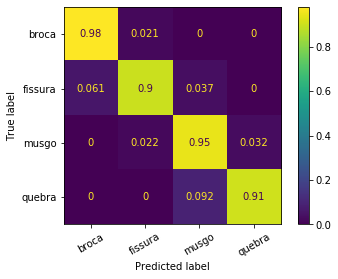

Rodada 8	-	Seed 7410
              precision    recall  f1-score   support

       broca       0.93      0.95      0.94        95
     fissura       0.96      0.92      0.94        97
       musgo       0.90      1.00      0.95        74
      quebra       1.00      0.93      0.97        92

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



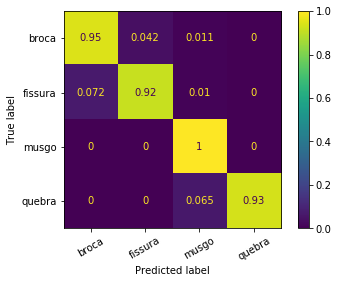

Rodada 9	-	Seed 5463
              precision    recall  f1-score   support

       broca       0.96      0.97      0.96        91
     fissura       0.96      0.94      0.95        81
       musgo       0.89      0.97      0.92        89
      quebra       0.97      0.90      0.93        97

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



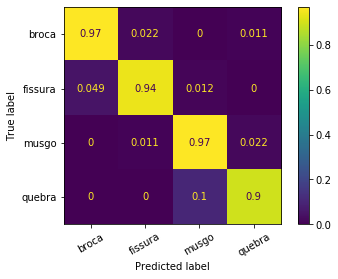

Rodada 10	-	Seed 6997
              precision    recall  f1-score   support

       broca       0.89      0.96      0.92        73
     fissura       0.96      0.89      0.92       100
       musgo       0.94      0.93      0.93       100
      quebra       0.93      0.95      0.94        85

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



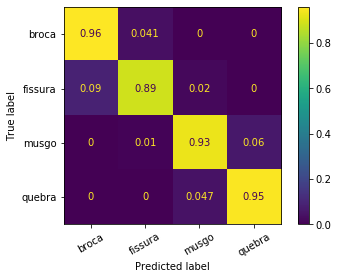

Rodada 11	-	Seed 643
              precision    recall  f1-score   support

       broca       0.95      0.93      0.94        89
     fissura       0.95      0.94      0.95        89
       musgo       0.87      0.99      0.93        90
      quebra       0.99      0.89      0.94        90

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



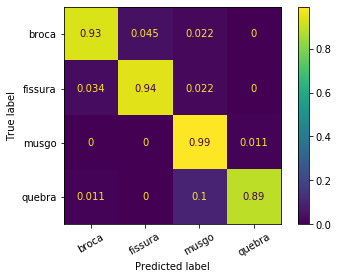

Rodada 12	-	Seed 5941
              precision    recall  f1-score   support

       broca       0.96      0.91      0.94        81
     fissura       0.90      0.96      0.93        99
       musgo       0.91      0.92      0.92        92
      quebra       0.95      0.92      0.93        86

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



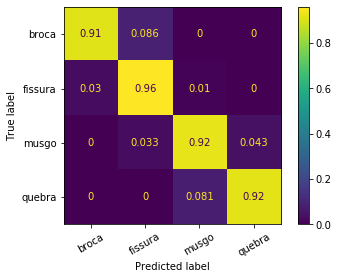

Rodada 13	-	Seed 3786
              precision    recall  f1-score   support

       broca       0.91      0.96      0.94        83
     fissura       0.99      0.90      0.94        87
       musgo       0.94      0.97      0.95        97
      quebra       0.97      0.97      0.97        91

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



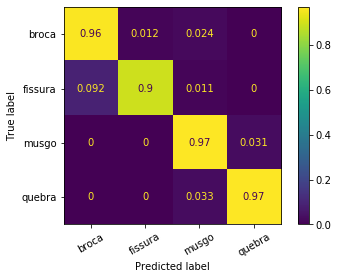

Rodada 14	-	Seed 1055
              precision    recall  f1-score   support

       broca       0.99      0.93      0.96        87
     fissura       0.93      0.93      0.93        97
       musgo       0.90      0.96      0.92        90
      quebra       0.96      0.95      0.96        84

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



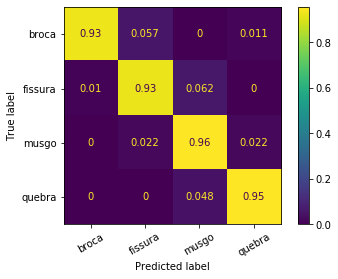

Rodada 15	-	Seed 4481
              precision    recall  f1-score   support

       broca       0.98      0.95      0.97        88
     fissura       0.97      0.95      0.96        81
       musgo       0.95      0.97      0.96        97
      quebra       0.97      0.99      0.98        92

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



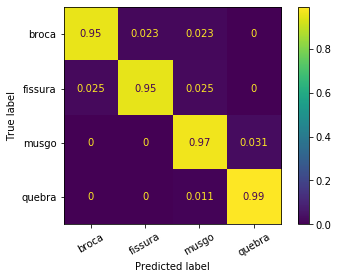

Rodada 16	-	Seed 6274
              precision    recall  f1-score   support

       broca       0.92      0.94      0.93        95
     fissura       0.95      0.87      0.91        89
       musgo       0.89      0.99      0.94        89
      quebra       1.00      0.95      0.98        85

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



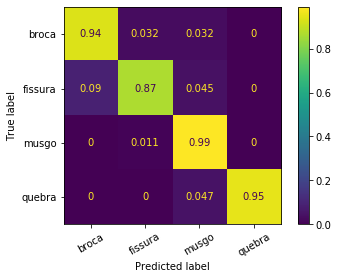

Rodada 17	-	Seed 6293
              precision    recall  f1-score   support

       broca       0.97      0.91      0.94        91
     fissura       0.93      0.94      0.94       100
       musgo       0.90      0.99      0.94        88
      quebra       1.00      0.94      0.97        79

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.95       358
weighted avg       0.95      0.94      0.94       358



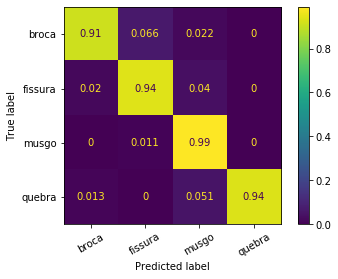

Rodada 18	-	Seed 973
              precision    recall  f1-score   support

       broca       0.97      0.97      0.97        97
     fissura       0.99      0.93      0.96        87
       musgo       0.88      0.99      0.93        87
      quebra       0.99      0.92      0.95        87

    accuracy                           0.95       358
   macro avg       0.96      0.95      0.95       358
weighted avg       0.96      0.95      0.95       358



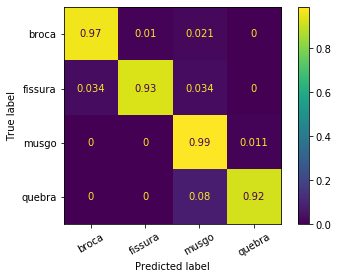

Rodada 19	-	Seed 2561
              precision    recall  f1-score   support

       broca       1.00      0.93      0.96        95
     fissura       0.91      0.98      0.94        82
       musgo       0.93      0.94      0.94        85
      quebra       0.97      0.97      0.97        96

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



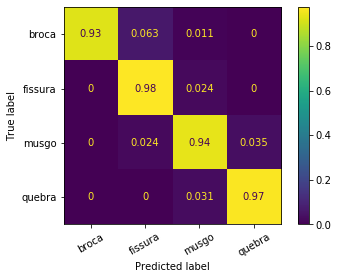

Rodada 20	-	Seed 2020
              precision    recall  f1-score   support

       broca       0.96      0.97      0.96        96
     fissura       0.96      0.95      0.96        86
       musgo       0.95      0.97      0.96        94
      quebra       0.97      0.95      0.96        82

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



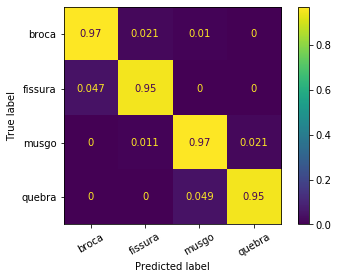

Rodada 21	-	Seed 1297
              precision    recall  f1-score   support

       broca       0.93      0.93      0.93        96
     fissura       0.88      0.92      0.90        83
       musgo       0.96      0.95      0.95        93
      quebra       0.98      0.95      0.96        86

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



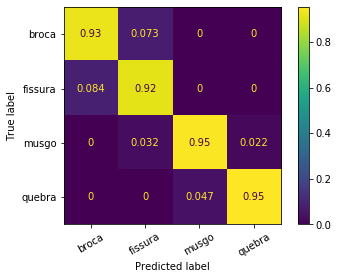

Rodada 22	-	Seed 3507
              precision    recall  f1-score   support

       broca       0.96      0.88      0.92        91
     fissura       0.87      0.98      0.92        82
       musgo       0.95      0.93      0.94        89
      quebra       0.96      0.96      0.96        96

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



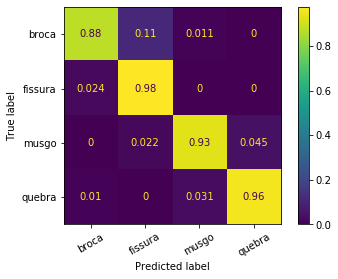

Rodada 23	-	Seed 3009
              precision    recall  f1-score   support

       broca       0.98      0.98      0.98        91
     fissura       0.97      0.97      0.97        75
       musgo       0.97      0.96      0.96       100
      quebra       0.96      0.97      0.96        92

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



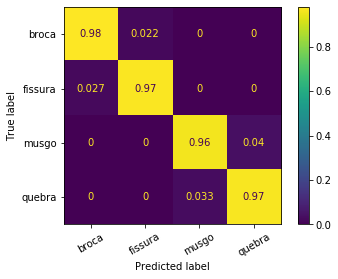

Rodada 24	-	Seed 6491
              precision    recall  f1-score   support

       broca       0.93      0.90      0.92        91
     fissura       0.93      0.93      0.93        96
       musgo       0.90      0.97      0.93        94
      quebra       0.96      0.91      0.93        77

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



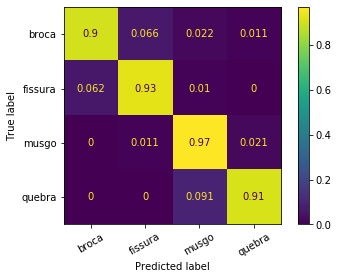

Rodada 25	-	Seed 7470
              precision    recall  f1-score   support

       broca       0.95      0.94      0.95        84
     fissura       0.95      0.94      0.94        81
       musgo       0.92      0.97      0.95       101
      quebra       0.98      0.95      0.96        92

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



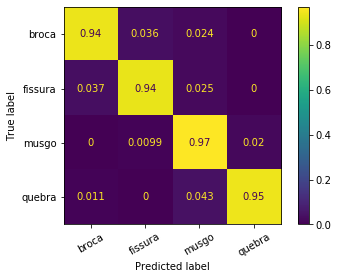

Rodada 26	-	Seed 4869
              precision    recall  f1-score   support

       broca       0.95      0.96      0.95        94
     fissura       0.94      0.93      0.93        82
       musgo       0.90      0.98      0.94        93
      quebra       0.99      0.90      0.94        89

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



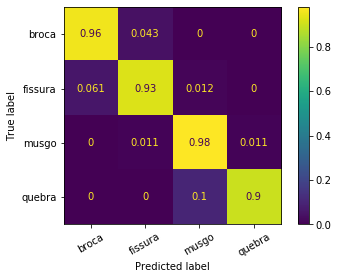

Rodada 27	-	Seed 6179
              precision    recall  f1-score   support

       broca       0.94      0.92      0.93        90
     fissura       0.92      0.92      0.92        95
       musgo       0.87      0.94      0.90        89
      quebra       0.96      0.89      0.93        84

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



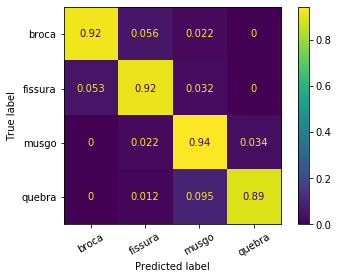

Rodada 28	-	Seed 1598
              precision    recall  f1-score   support

       broca       1.00      0.96      0.98        92
     fissura       0.93      1.00      0.96        92
       musgo       0.96      0.93      0.94        91
      quebra       0.96      0.95      0.96        83

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



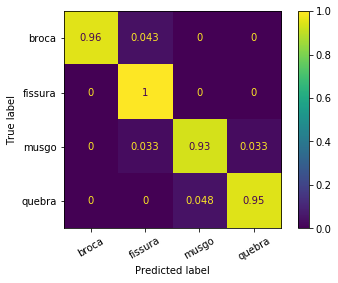

Rodada 29	-	Seed 5211
              precision    recall  f1-score   support

       broca       0.94      0.96      0.95        85
     fissura       0.99      0.93      0.96        88
       musgo       0.93      0.98      0.95        97
      quebra       0.98      0.95      0.97        88

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



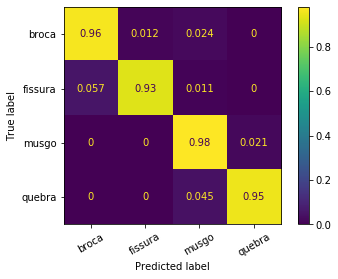

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

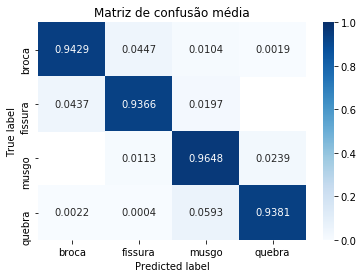

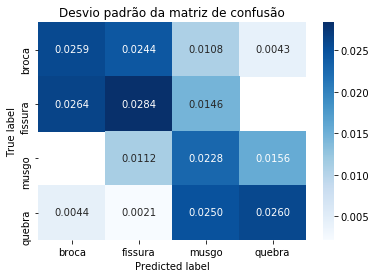

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia   f1-broca  f1-fissura   f1-musgo  f1-quebra
count  30.000000  30.000000   30.000000  30.000000  30.000000
mean    0.945624   0.947730    0.939758   0.940649   0.954489
std     0.012636   0.018666    0.018461   0.015437   0.015153
min     0.918994   0.911243    0.899408   0.903226   0.925926
25%     0.935754   0.935729    0.927271   0.930307   0.941176
50%     0.944134   0.951051    0.939759   0.940859   0.958209
75%     0.956704   0.963304    0.956280   0.954659   0.966017
max     0.969274   0.978022    0.973333   0.964824   0.978495


Acurácia,f1-broca,f1-fissura,f1-musgo,f1-quebra
0.935754,0.935897,0.938389,0.923077,0.944444
0.944134,0.949721,0.944785,0.941176,0.941176
0.963687,0.956522,0.962567,0.958763,0.977011
0.958101,0.963855,0.955556,0.957346,0.955975
0.960894,0.962025,0.956522,0.957895,0.966184
0.938547,0.911243,0.916201,0.960000,0.964286
0.944134,0.965909,0.939759,0.932039,0.940476
0.935754,0.964103,0.925000,0.916667,0.934911
0.946927,0.937500,0.936842,0.948718,0.966292
0.941341,0.961749,0.950000,0.924731,0.930481


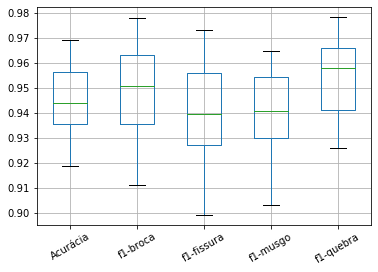

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')